## Document Clustering and Classifications with Python
Followed outline and directions from http://brandonrose.org/clustering

In [1]:
#Import modules needed
import numpy as np
import pandas as pd
import codecs
from sklearn import feature_extraction
import mpld3
import nltk
from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import string
import os, csv, sys, re
from nltk.collocations import *
from timeit import default_timer as timer


/Users/dariaulybina/anaconda/envs/envr/lib/python3.5/site-packages/nltk/decorators.py:59: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  regargs, varargs, varkwargs, defaults = inspect.getargspec(func)


I have a summary csv file that contains short summary of each document, filename and a list of tags already assigned to documents by the IMF snd scraped.
2 primary lists are __rawSum__ and __rawTag__.

In [3]:
#Define the location of your file with text to analyse and extract data
direct = '/Users/dariaulybina/Desktop/georgetown/global-economics/scrape_articles/summary_tables_2000.csv'
data = list(csv.DictReader(open(direct, encoding = 'latin1')))

rawSum = []
rawDoc = []
rawTag = []

for row in data:
    rawTag.append(row['Subject'])
    rawSum.append(row['Description'])
    rawDoc.append(row['Filename'])

In [4]:
print(len(rawSum)) # number of documents
print(rawSum[0:10]) #first 10 titles

1745
['Over the past five years, Somalia has marked important milestones in rebuilding its economy and normalizing relations with international financial institutions. After more than two decades of a civil war that caused significant damage to the country\x89Ûªs social and economic infrastructure, the Federal Government of Somalia (FGS) was elected and recognized by the international community in 2012. With donors\x89Ûª support, progress is being made in the FGS\x89Ûªs efforts to improve security, capacity development, and state building. However, significant challenges remain ahead to rebuild the economy and institutions and improve social conditions. The IMF resumed its relationship with Somalia in 2013 and has since been heavily involved in the provision \nof policy advice and technical assistance, particularly in the context of the 12-month Staff-Monitored Program (SMP) which was approved by the IMF Managing Director in May 2016. Despite a very difficult political environment and 

In [5]:
# load nltk's SnowballStemmer (imported) as variabled 'stemmer'
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

Below three functions are defined:

__tokenize_and_stem__: tokenizes (splits text into a list of its respective words (or tokens) and also stems each token

__tokenize_only__: tokenizes the texts only

__tokenize_and_lemmatize__: tokenizes into a list of its respective words and create lemmas for words

Those function are used to create a dictionary which becomes important in case I want to use stems for an algorithm, but later convert stems back to their full words for presentation purposes.
In case you would like to learn more about stemming versus lemmatization: https://www.quora.com/What-is-difference-between-stemming-and-lemmatization

In [6]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [7]:
def tokenize_and_lemmatize(text):
    text = text.lower()
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemmas = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    filter_lemmas = [w for w in lemmas if not w in stopwords.words('english')]
    count = Counter(filter_lemmas)
    #In case you want to see 5 most common lemmas for each document
    #print('5 most common lemmas without stopwords in the last document: {}'.format(count.most_common(5)))
    return lemmas, filter_lemmas

In [8]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

The code below uses stemming/tokenizing lemmas/tokenizing and tokenizing functions to iterate over the list of contents to create vocabularies: stemmed, lemmatized and one only tokenized.

In [9]:
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
totalvocab_lemmatized = []
for i in rawSum:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'content', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)
    
    allwords_lemmas, filter_lemmas = tokenize_and_lemmatize(i)
    totalvocab_lemmatized.extend(allwords_lemmas)


vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_lemmas = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_lemmatized)
print('there are {} items in vocab_frame'.format(str(vocab_frame.shape[0])))
print('there are {} items in vocab_lemmas'.format(str(vocab_lemmas.shape[0])))

print(vocab_frame.head())
print(vocab_lemmas.head())

there are 164117 items in vocab_frame
there are 164117 items in vocab_lemmas
      words
over   over
the     the
past   past
five   five
year  years
      words
over   over
the     the
past   past
five   five
year  years


### Tf-idf and document similarity

Define term frequency-inverse document frequency (tf-idf) vectorizer parameters and then convert the synopses list into a tf-idf matrix.
To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm).
Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

Defined parameters:

__max_df__: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining.

__min_idf__: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.1; the term must be in at least 10% of the document. Sometimes lower min_df you allow - more rare clustering will show up, for example, names- "Michael" or "Tom" found in several of the documents.

__ngram_range__: lookinf at unigrams, bigrams and trigrams or different.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
import time

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
startTF = timer()
tfidf_matrix = tfidf_vectorizer.fit_transform(rawSum) #fit the vectorizer to contents
endFT = timer()
print("Total time to vectorize contents: {} seconds".format(endFT-startTF))
    
print(tfidf_matrix.shape)

#Terms - list of features used in tf-idf matrix
terms = tfidf_vectorizer.get_feature_names()

Total time to vectorize contents: 5.7391254600006505 seconds
(1745, 129)


In this particular example we got 129 features ('important words') with parameters set (0.8, 0.1, 3). Experiment with different parameters to see how the number of quality of features changes. 

In [12]:
print(terms)

['account', 'activ', 'articl', 'articl iv', 'articl iv consult', 'author', 'balanc', 'bank', 'budget', 'challeng', 'commend', 'condit', 'consolid', 'consult', 'consult highlight', 'continu', 'credit', 'crisi', 'current', 'current account', 'debt', 'declin', 'deficit', 'demand', 'despit', 'develop', 'director', 'discuss', 'domest', 'econom', 'econom growth', 'economi', 'environ', 'exchang', 'exchang rate', 'execut', 'execut director', 'expect', 'export', 'extern', 'financ', 'financi', 'financi sector', 'fiscal', 'fiscal polici', 'focus', 'framework', 'gdp', 'gdp growth', 'global', 'govern', 'growth', 'help', 'high', 'highlight', 'implement', 'import', 'improv', 'increas', 'inflat', 'intern', 'invest', 'iv', 'iv consult', 'iv consult highlight', 'key', 'larg', 'low', 'macroeconom', 'manag', 'market', 'measur', 'medium-term', 'monetari', 'monetari polici', 'need', 'new', 'oil', 'outlook', 'owe', 'paper', 'percent', 'perform', 'polici', 'posit', 'poverti', 'price', 'privat', 'product', 'pr

__Dist__ is defined as 1 - the cosine similarity of each document. Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.
Note that with dist it is possible to evaluate the similarity of any two or more texts.

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

### K-means clustering

Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the your texts. I first chose k-means. K-means initializes with a pre-determined number of clusters. 

1. Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares.

2. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. 

3. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

(Note: it could take several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima.)

In [15]:
from sklearn.cluster import KMeans
from sklearn.externals import joblib

num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

#Uncomment and change directory if you want to save the file locally
#joblib.dump(km, '/Users/dariaulybina/Desktop/georgetown/global-economics/scrape_articles/doc_cluster_lda.pkl')
km = joblib.load('/Users/dariaulybina/Desktop/georgetown/global-economics/scrape_articles/doc_cluster_lda.pkl')

clusters = km.labels_.tolist()

results = { 'Doc': rawDoc, 'Summary': rawSum, 'Tag': rawTag,'cluster': clusters }
frame = pd.DataFrame(results, index = [clusters] , columns = ['Doc', 'Summary','Tag','cluster'])
frame['cluster'].value_counts()  #number of docs per cluster (clusters from 0 to 4)

4    495
3    468
1    333
0    324
2    125
Name: cluster, dtype: int64

In [ ]:
#Running this code instead of above will produce output for 10 clusters

num_clusters = 10
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

joblib.dump(km,  '/Users/dariaulybina/Desktop/georgetown/global-economics/scrape_articles/doc_cluster10_lda.pkl')
km10 = joblib.load('/Users/dariaulybina/Desktop/georgetown/global-economics/scrape_articles/doc_cluster10_lda.pkl')

clusters = km.labels_.tolist()

results = { 'Doc': rawDoc, 'Summary': rawSum, 'Tag': rawTag,'cluster': clusters }
frame = pd.DataFrame(results, index = [clusters] , columns = ['Doc', 'Summary','Tag','cluster'])
frame['cluster'].value_counts()  #number of docs per cluster (clusters from 0 to 4)

In [23]:
def sort_clusters_by_proximity(km, num_clusters, vocab_frame):
    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print("Top terms per cluster:")
    print()
    for i in range(num_clusters):
        print("Cluster %d words:" % i, end='')
        
        for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
            print('{}'.format(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=','))
        print() #add whitespace
        print() #add whitespace
        
        print("Cluster %d assigned tags:" % i, end='') #or you can replace Tag with Doc to see documents' names
        for tag in frame.ix[i]['Tag'].values.tolist():
            print(' %s,' % tag, end='')
        print() #add whitespace
        print() #add whitespace
    return order_centroids

In [24]:
order_centroids = sort_clusters_by_proximity(km, num_clusters, vocab_frame)
print()
print()

Top terms per cluster:

Cluster 0 words:b'director'
b'executive'
b'executive'
b'welcome'
b'fiscal'
b'policy'




Cluster 1 words:b'report'
b'article'
b'article'
b'iv'
b'consultation'
b'article'




Cluster 2 words:b'program'
b'poverty'
b'reduction'
b'performance'
b'paper'
b'growth'




Cluster 3 words:b'policy'
b'fiscal'
b'financial'
b'growth'
b'reforms'
b'economy'




Cluster 4 words:b'percent'
b'growth'
b'gdp'
b'iv'
b'consultation'
b'highlights'








### Multidimentional Scaling

Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. 

Another option would be to use principal __component analysis (PCA)__.


In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

### Visualizing document clusters

Visualizing the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).

Steps:

1. define some dictionaries for going from cluster number to color and to cluster name.

2. based the cluster names off the words that were closest to each cluster centroid.

In [25]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'director, executive, welcome, fiscal, policy',
                 1: 'article, iv, report, cosultation',
                 2: 'program, poverty, reduction, performance, paper, growth',
                 3: 'policy, fiscal, financial, growth, rforms, economy',
                 4: 'percent, growth, gdp, iv, consultation, highlights'
                }

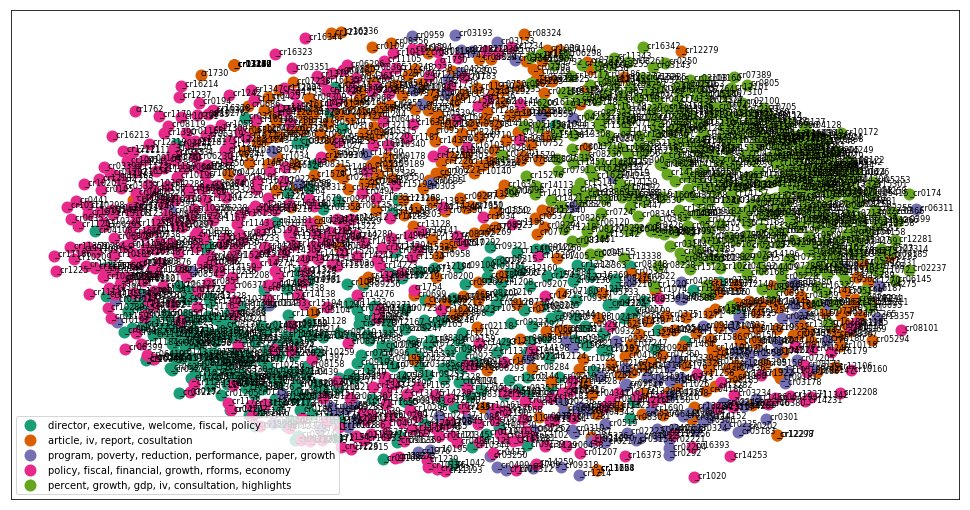

In [33]:
-

In [28]:
plt.close()

__Dealing with overlapping labels:__

Mpld3 basically let's you use matplotlib syntax to create web interactives. It has a really easy, high-level API for adding tooltips on mouse hover.

It also has some nice functionality for zooming and panning. The below javascript snippet basicaly defines a custom location for where the zoom/pan toggle resides. 

The only thing you might want to change is the x and y attr for the position of the toolbar.

In [29]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 800);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

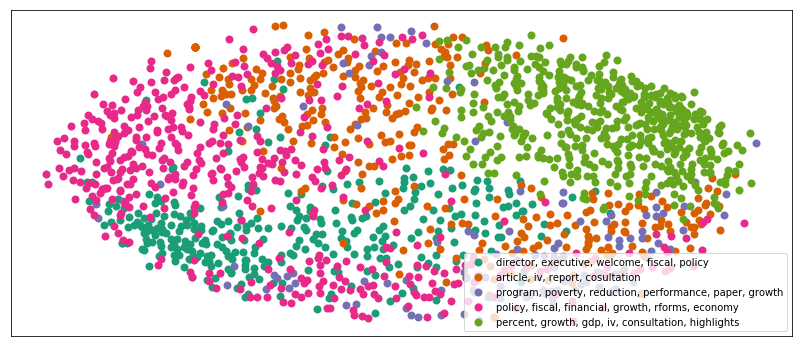

In [32]:
## create data frame that has the result of the MDS plus the cluster numbers and document titles (!!!!!!!!)
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=rawDoc)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot


#mpld3.show() #not the best way - you will have to interupt kernel - good for stand-along scripts
#mpld3.enable_notebook()
mpld3.display() #show the plot
#mpld3.disable_notebook()

#uncomment the below to export to html
html = mpld3.fig_to_html(fig)
#print(html)

### Hierarchical document clustering

Another algorithm is __Ward clustering algorithm__ that offers hierarchical clustering. 

Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. 

Use recomputed cosine distance matrix (dist) to calclate a linkage_matrix, which you can then plot as a dendrogram.

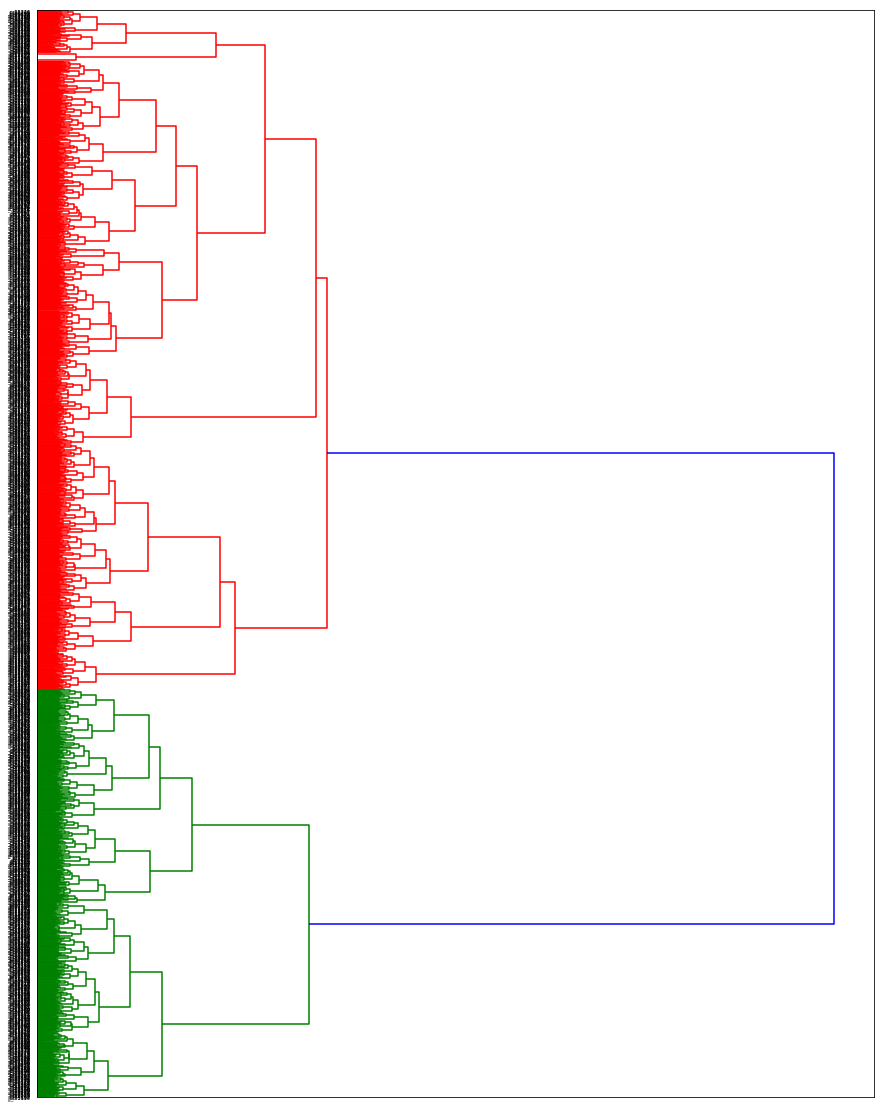

In [34]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=rawDoc);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

#plt.tight_layout() #show plot with tight layout
#plt.show()
#uncomment below to save figure
plt.savefig('/Users/dariaulybina/Desktop/georgetown/global-economics/scrape_articles/ward_clusters.png', dpi=100) #save figure as ward_clusters

In [35]:
plt.close()

### Latent Dirichlet Allocation

This section focuses on using Latent Dirichlet Allocation (LDA) to learn yet more about the hidden structure of texts.

LDA is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics.

__Gensim__ pacakage is used for LDA implementation. 

Steps:

1. Remove any verb words and punctuation

2. Remove stopwords for stemed and lemmatized tokens

3. Create Gensim dictionary

4. Remove extremes (similar to the min/max df step used when creating the tf-idf matrix)


In [40]:
from gensim import corpora, models, similarities
stopwords = nltk.corpus.stopwords.words('english')

def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

def strip_verbs_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_verb = [word for word,pos in tagged if pos != 'VBZ']
    return non_verb

preprocess = [strip_proppers(doc) for doc in rawSum]
tokenized_text = [tokenize_and_stem(text) for text in preprocess]

texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)
 

In [41]:
#Print results to csv file and save it
myList = []
for i in range(0,len(rawSum)):
    myDict = {
        'Doc': rawDoc[i],
        'Sum': rawSum[i],
        'Subject':rawTag[i],
        'Stems': list(set(texts[i]))
    }
    myList.append(myDict)

header = ['Doc','Sum','Subject','Stems']

with open('/Users/dariaulybina/Desktop/georgetown/global-economics/scrape_articles/LDA_dictionary.csv', 'w', newline='', encoding ='utf-8') as csvfile1:
    writer = csv.DictWriter(csvfile1, header)
    writer.writeheader()
    writer.writerows(myList)
    csvfile1.close()


The code below explores LDA and took too long to run - I didn't finish it :(

In [42]:
#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

lda = models.LdaModel(corpus, num_topics=5, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=10000, 
                            passes=100)

lda.show_topics()
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix = np.array(topics_matrix, dtype=object)

topic_words = topics_matrix[:,:,1]
for i in topic_words:
    print([str(word) for word in i])
    print()

KeyboardInterrupt: 